<a href="https://colab.research.google.com/github/gontcharovd/AZ-104-MicrosoftAzureAdministrator/blob/master/notebook/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
from plotnine import ggplot, aes, geom_line, labs, theme_minimal, theme, scale_x_datetime, geom_bar, geom_smooth, facet_wrap, geom_histogram, scale_x_continuous

In [2]:
TEMPERATURES = [f'SP2_Temp_Regelkreis0{i}' for i in range(1, 10)]
METERS = ['SP2_Meterz_Einl', 'SP2_Meterz_Ausl', 'SP2_Diff_EA_Me']
SPEEDS = ['SP2_Geschw_Einl', 'SP2_Geschw_Ausl', 'SP2_Geschwindigkeit', 'SP2_Diff_EA_Ge']
MOISTURES = ['SP2_Rest_Fe_Li', 'SP2_Rest_Fe_Mi', 'SP2_Rest_Fe_Re']
GROUPING = ['artikel', 'artikel_bez', 'ag_bez']

SCHEMA = {
    'capture_ts': 'int64',
    'object_id': 'string',
    'value_decimal': 'float64',
    'artikel': 'string',
    'artikel_bez': 'string',
    'ag_bez': 'string'
}

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# Read and process data

In [4]:
data = pd.read_parquet("/content/drive/MyDrive/Juna/data/sp2_data.parquet")
data = data.astype(SCHEMA)
data['capture_ts'] = pd.to_datetime(data['capture_ts'], unit='ns')
# add temporal grouping variables
data['year'] = data['capture_ts'].dt.year
data['month'] = data['capture_ts'].dt.month
data['day'] = data['capture_ts'].dt.day

## Cast data to wide format

In [5]:
data_wide = data.pivot_table(
    index=['capture_ts', 'artikel', 'artikel_bez', 'ag_bez'],
    columns='object_id',
    values='value_decimal',
    aggfunc='first'
).reset_index()

In [6]:
# remove the `object_id` column and reset the index to a simple integer
data_wide = data_wide.reset_index(drop=True)
data_wide.columns.name = None

In [7]:
# sort values by ascending timestamp
data_wide = data_wide.sort_values('capture_ts').reset_index()

In [8]:
num_artikel = len(data_wide[data_wide['artikel'].isna()])
f'There are {num_artikel} rows with missing `artikel` values'

'There are 0 rows with missing `artikel` values'

## Create a run-length ID

* The `rleid` assigns a unique integer to all the timestamps of an individual product being produced on the machine
* Each time a new product is produced, i.e. the `artikel` changes, the `rleid` is incremented

In [9]:
data_wide['rleid'] = (data_wide['artikel'] != data_wide['artikel'].shift()).cumsum()
# The first row's run length id can't be calculated (because there is no previous row)
# therefore we set is to manually
data_wide.loc[0, 'rleid'] = 0

In [10]:
pd.concat([
  data_wide[data_wide['rleid'] == 1].tail(),
  data_wide[data_wide['rleid'] == 2].head()
], axis=0)[['capture_ts', 'artikel', 'rleid']]

,capture_ts,artikel,rleid
6036,2020-01-06 20:22:58,C534K55 YB 1355,1
6037,2020-01-06 20:23:01,C534K55 YB 1355,1
6038,2020-01-06 20:23:03,C534K55 YB 1355,1
6039,2020-01-06 20:23:04,C534K55 YB 1355,1
6040,2020-01-06 20:23:08,C534K55 YB 1355,1
6041,2020-01-06 20:30:20,C511D55 YB 1355,2
6042,2020-01-06 20:30:21,C511D55 YB 1355,2
6043,2020-01-06 20:30:22,C511D55 YB 1355,2
6044,2020-01-06 20:30:23,C511D55 YB 1355,2
6045,2020-01-06 20:30:24,C511D55 YB 1355,2


# Missing values

* Temperatures have about 25% missing values
* Speeds, meters, and moisture have about 60% missing values

## Raw data

In [11]:
data_wide.apply(lambda col: col.notnull().mean() * 100)

,0
index,100.000000
capture_ts,100.000000
artikel,100.000000
artikel_bez,100.000000
ag_bez,100.000000
SP2_Diff_EA_Ge,41.912079
SP2_Diff_EA_Me,41.912079
SP2_Geschw_Ausl,41.912079
SP2_Geschw_Einl,41.912048
SP2_Geschwindigkeit,49.843509


## Forward fill
* The various sensors register values at different timestamps, therefore the wide dataset necessarily contains missing values
* We forward-fill the missing values of all numeric columns for each `rleid`
* We group by both `rleid` **and** `ag_bez` because we don't want to forward fill missing values when respecitvely the product and product step change
* The forward fill fixed the missing values for temperature sensors, but not for the other sensors (speed, meters, and moisture). This means that other sensors measure at a higher frequency than temperature sensors

In [12]:
value_columns = TEMPERATURES + SPEEDS + METERS + MOISTURES
data_wide[value_columns] = data_wide.groupby(
    ['rleid', 'ag_bez'])[value_columns].transform(lambda group: group.ffill())

In [13]:
data_wide[value_columns].apply(lambda col: col.notnull().mean() * 100)

,0
SP2_Temp_Regelkreis01,98.289226
SP2_Temp_Regelkreis02,98.288228
SP2_Temp_Regelkreis03,98.288758
SP2_Temp_Regelkreis04,98.287635
SP2_Temp_Regelkreis05,98.287136
SP2_Temp_Regelkreis06,98.287760
SP2_Temp_Regelkreis07,98.288353
SP2_Temp_Regelkreis08,98.288290
SP2_Temp_Regelkreis09,98.290100
SP2_Geschw_Einl,41.912110


In [14]:
data_wide.loc[
    data_wide[['SP2_Geschw_Einl', 'SP2_Temp_Regelkreis01']].notnull().all(axis=1), value_columns
].apply(lambda col: col.notnull().mean() * 100)

,0
SP2_Temp_Regelkreis01,100.0
SP2_Temp_Regelkreis02,100.0
SP2_Temp_Regelkreis03,100.0
SP2_Temp_Regelkreis04,100.0
SP2_Temp_Regelkreis05,100.0
SP2_Temp_Regelkreis06,100.0
SP2_Temp_Regelkreis07,100.0
SP2_Temp_Regelkreis08,100.0
SP2_Temp_Regelkreis09,100.0
SP2_Geschw_Einl,100.0


In [15]:
data_wide_clean = data_wide[
    data_wide[['SP2_Geschw_Einl', 'SP2_Temp_Regelkreis01']
].notnull().all(axis=1)].drop(
        columns=['SP2_Geschwindigkeit', 'index']
    ).reset_index(drop=True) # we no longer need the `object_id` in wide format

In [16]:
f'There are {len(data_wide_clean) / len(data_wide) * 100:.2f}% of rows remaining'

'There are 41.03% of rows remaining'

# Product data

## Class imbalance

* There are only 3 distinct production steps `artikel_bez`
* The **ERA FALTENBALGMATERI** and **SCHLEIFMITTELTRÄGER** product categories have almost no articles
* The top 4 produced products represent 12.63% of the cleaned data

In [17]:
data_group = data_wide_clean[['artikel', 'artikel_bez', 'ag_bez']].drop_duplicates()

In [18]:
data_wide_clean['rleid'].nunique()

2284

In [19]:
for group in ['artikel', 'artikel_bez', 'ag_bez']:
    print(f'total {group}: {data_group[group].nunique()}')

total artikel: 166
total artikel_bez: 2
total ag_bez: 97


In [20]:
data_group.groupby('artikel_bez')['artikel'].nunique()

,artikel
artikel_bez,
SCHLEIFMITTELGEWEBE,164
SCHLEIFMITTELTRÄGER,2


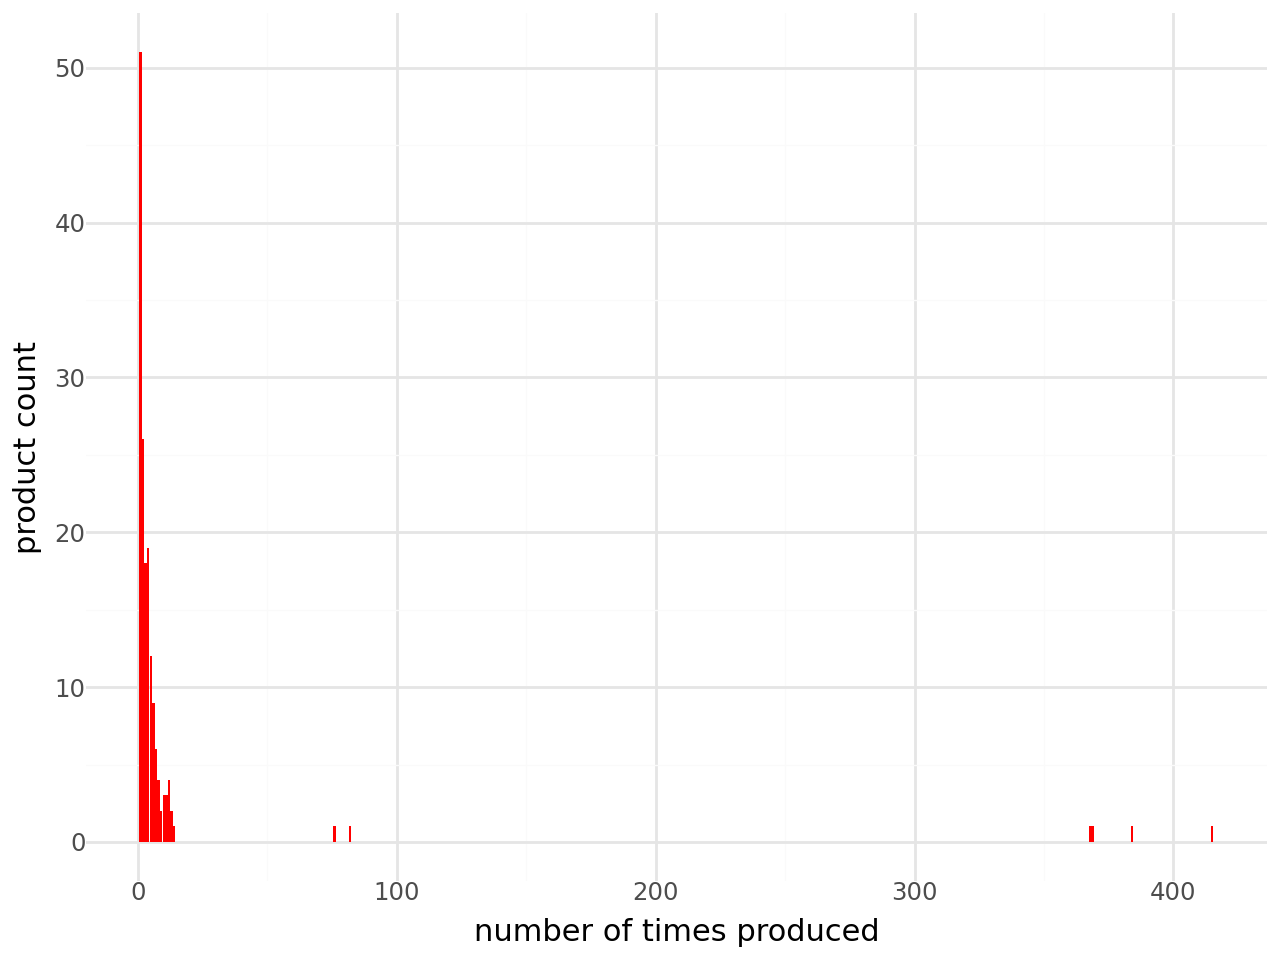

In [21]:
data_product_counts = data_wide_clean.groupby(['artikel'])['rleid'].nunique().reset_index().sort_values('rleid')
(ggplot(data_product_counts, aes(x='rleid')) +
    geom_bar(fill="red") +
    labs(x="number of times produced", y="product count") +
    theme_minimal()
)

In [22]:
data_product_counts[data_product_counts['rleid'] > 50].head(6)

,artikel,rleid
127,G777H41 YB 1620,76
134,G777H83 YB 1650,82
61,C550C73 YB 1570,368
42,C534K55 YB 1355,369
92,F511C14 ZB 1440,384
93,F511C14 ZB 1590,415


In [23]:
product_list = data_product_counts.loc[data_product_counts['rleid'] > 300, 'artikel'].unique().tolist()

In [24]:
len_data_wide_clean = len(data_wide_clean)
len_data_wide_clean_product = len(data_wide_clean[data_wide_clean['artikel'].isin(product_list)])
f'These {len(product_list)} products represent {len_data_wide_clean_product / len_data_wide_clean * 100:.2f}% of the cleaned data'

'These 4 products represent 12.63% of the cleaned data'

In [25]:
# overwrite data_clean
data_wide_clean = data_wide_clean[data_wide_clean['artikel'].isin(product_list)]

# recreate long data
data_long_clean = data_wide_clean.melt(
    id_vars=['capture_ts', 'artikel', 'artikel_bez', 'ag_bez', 'rleid'],
    var_name='object_id',
    value_name='value_decimal'
)

# Production steps

* One product `rleid` can have either one or two production steps `ag_bez`
* Sensor values `SP2_Temp_Regelkreis01` differs for two `ag_bez` of the same `artikel`
* This means we can't just ignore `ag_bez`


In [26]:
num_ag_bez = data_wide_clean.groupby(['artikel', 'rleid'])['ag_bez'].nunique().reset_index()

In [27]:
# one product has either one or two production steps
print(f"max production steps: {int(num_ag_bez['ag_bez'].max())}")
print(f"min production steps: {int(num_ag_bez['ag_bez'].min())}")

max production steps: 2
min production steps: 1


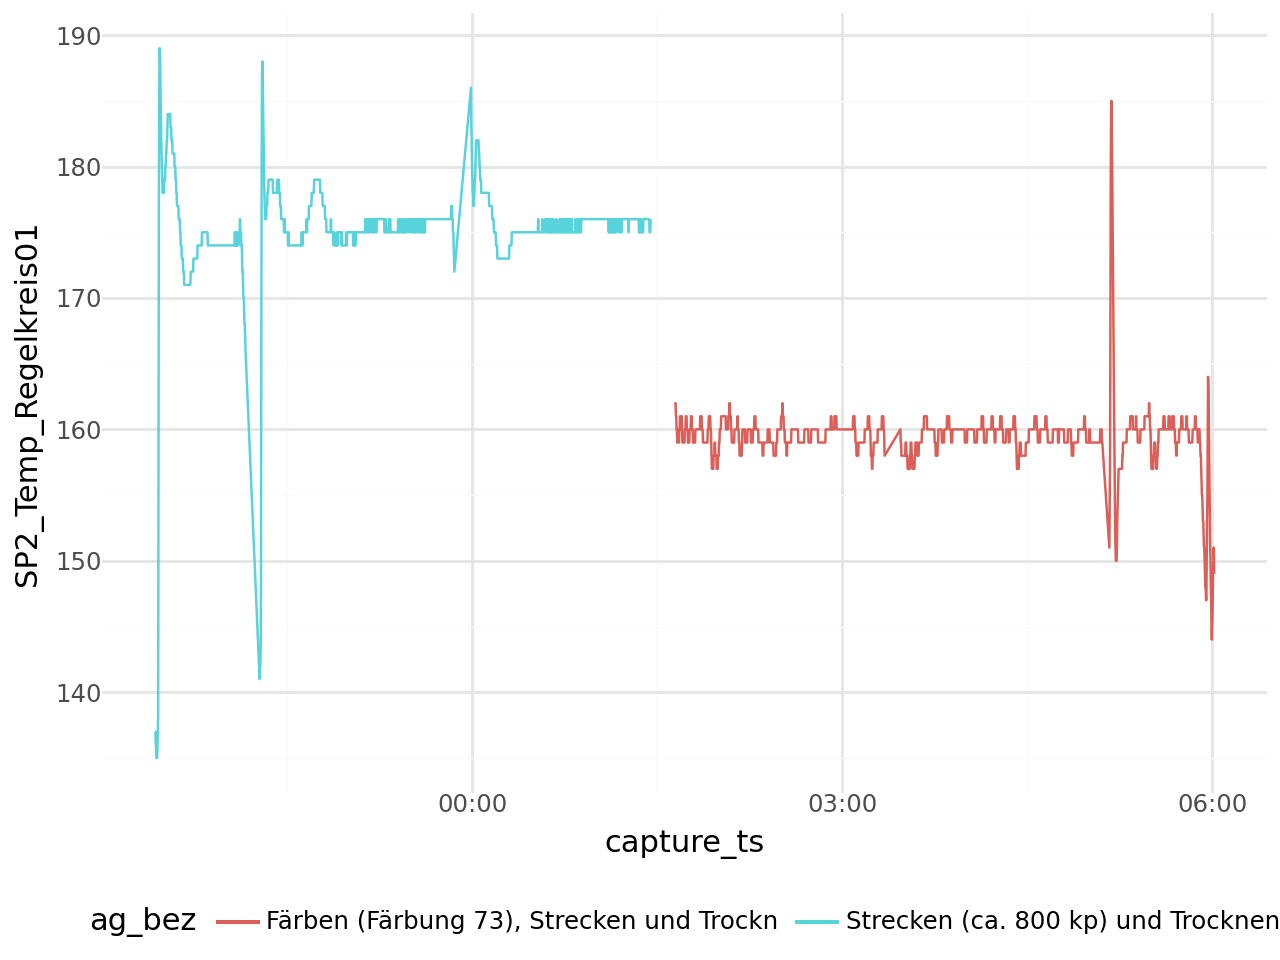

In [28]:
data_plot = data_wide_clean[data_wide_clean['rleid'] == 888].reset_index()
(
    ggplot(data_plot, aes(x='capture_ts', y='SP2_Temp_Regelkreis01', color='ag_bez')) +
    geom_line() +
    theme_minimal()+
    scale_x_datetime(date_labels="%H:%M") +
    theme(legend_position="bottom")
)

In [29]:
for p in data_wide_clean['ag_bez'].unique().tolist():
    print(p)

Imprägnieren, Kluppen, Kettseite oben, V
Trocknen + Strecken, min.700 kp, 6% +/-
Trocknen+Strecken,
Strecken (ca. 800 kp) und Trocknen
Färben (Färbung 73), Strecken und Trockn
Imprägnieren
Trocknen und Strecken


In [30]:
data_plot = data_long_clean[data_long_clean['rleid'] == 1761]

# Sensor data

## Speed

* Mass balance assumption doesn't hold: it's possible that `SP2_Geschw_Einl` != `SP2_Geschw_Ausl`
* Speed profile clearly depends on the operation `ag_bez`
* Perhaps stretching requires a higher speed out than speed in?

### Example

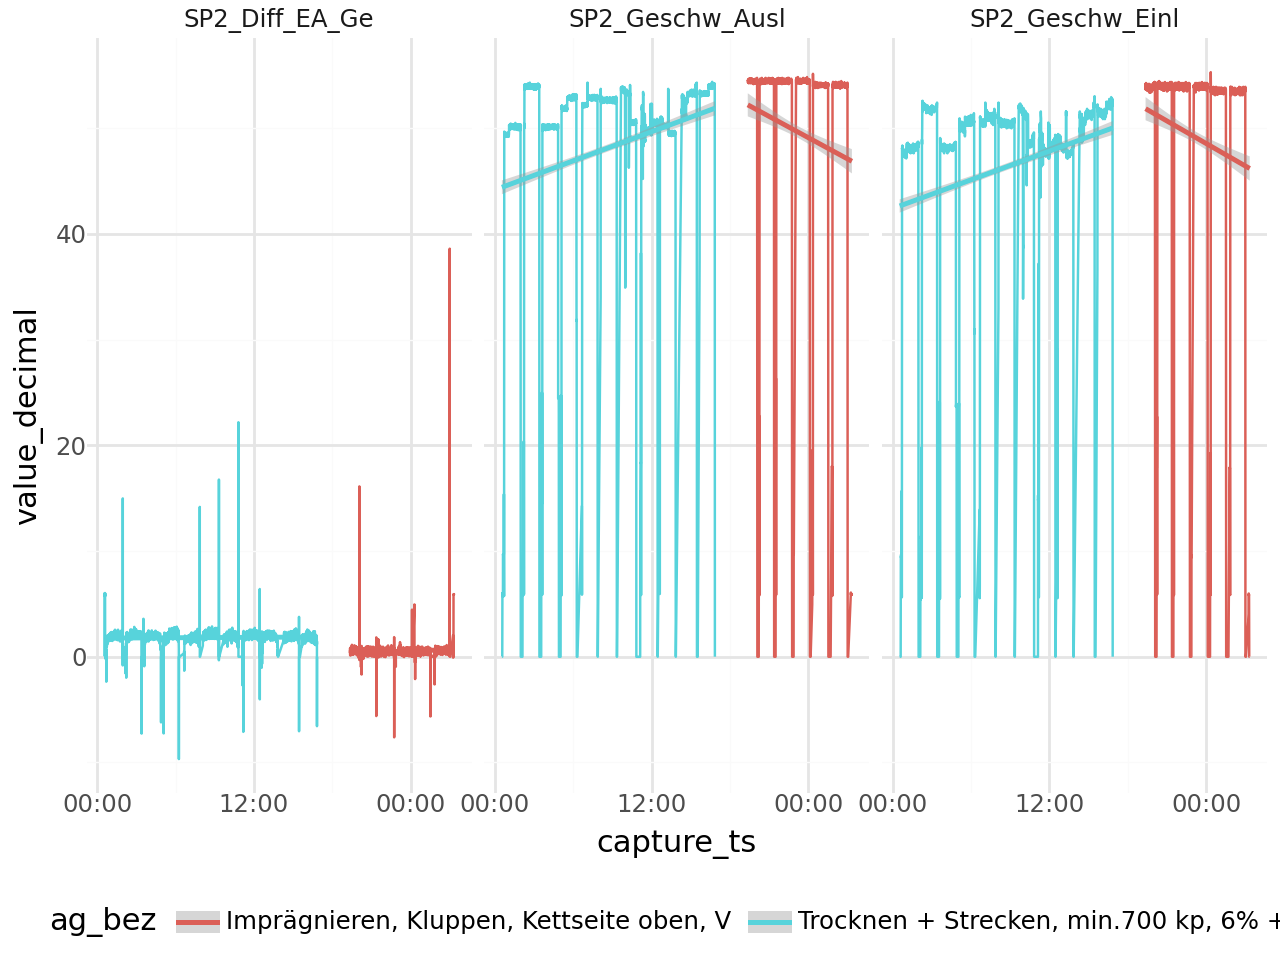

In [31]:
(
    ggplot(data_plot[data_plot['object_id'].isin(SPEEDS)], aes(x='capture_ts', y='value_decimal', color='ag_bez')) +
    geom_line() +
    theme_minimal()+
    scale_x_datetime(date_labels="%H:%M") +
    facet_wrap('~ object_id') +
    geom_smooth() +
    theme(legend_position="bottom")
)

### Envelope

In [32]:
speed_envelope = data_long_clean[data_long_clean['object_id'].isin(['SP2_Geschw_Einl', 'SP2_Geschw_Ausl'])
    ].groupby(['object_id', 'artikel', 'ag_bez'])['value_decimal'].agg(
        percentile_01_speed=lambda x: np.percentile(x, 1),
        percentile_99_speed=lambda x: np.percentile(x, 99)
    )
speed_envelope

percentile_01_speed  \
object_id       artikel         ag_bez                                                          
SP2_Geschw_Ausl C534K55 YB 1355 Trocknen und Strecken                                     0.0   
                                Trocknen+Strecken,                                        0.0   
                C550C73 YB 1570 Färben (Färbung 73), Strecken und Trockn                  0.0   
                                Strecken (ca. 800 kp) und Trocknen                        0.0   
                F511C14 ZB 1440 Imprägnieren, Kluppen, Kettseite oben, V                  0.0   
                                Trocknen + Strecken, min.700 kp, 6% +/-                   0.0   
                F511C14 ZB 1590 Imprägnieren                                              0.0   
                                Imprägnieren, Kluppen, Kettseite oben, V                  0.0   
                                Trocknen + Strecken, min.700 kp, 6% +/-                   0.0   
                                Trocknen und Strecken                                     0.0   
SP2_Geschw_Einl C534K55 YB 1355 Trocknen und Strecken                                     0.0   
                                Trocknen+Strecken,                                        0.0   
                C550C73 YB 1570 Färben (Färbung 73), Strecken und Trockn                  0.0   
                                Strecken (ca. 800 kp) und Trocknen                        0.0   
                F511C14 ZB 1440 Imprägnieren, Kluppen, Kettseite oben, V                  0.0   
                                Trocknen + Strecken, min.700 kp, 6% +/-                   0.0   
                F511C14 ZB 1590 Imprägnieren                                              0.0   
                                Imprägnieren, Kluppen, Kettseite oben, V                  0.0   
                                Trocknen + Strecken, min.700 kp, 6% +/-                   0.0   
                                Trocknen und Strecken                                     0.0   

                                                                          percentile_99_speed  
object_id       artikel         ag_bez                                                         
SP2_Geschw_Ausl C534K55 YB 1355 Trocknen und Strecken                               67.780479  
                                Trocknen+Strecken,                                  64.363899  
                C550C73 YB 1570 Färben (Färbung 73), Strecken und Trockn            54.673759  
                                Strecken (ca. 800 kp) und Trocknen                  70.184036  
                F511C14 ZB 1440 Imprägnieren, Kluppen, Kettseite oben, V            54.523140  
                                Trocknen + Strecken, min.700 kp, 6% +/-             53.419430  
                F511C14 ZB 1590 Imprägnieren                                        54.598351  
                                Imprägnieren, Kluppen, Kettseite oben, V            54.825211  
                                Trocknen + Strecken, min.700 kp, 6% +/-             58.125992  
                                Trocknen und Strecken                               58.555920  
SP2_Geschw_Einl C534K55 YB 1355 Trocknen und Strecken                               65.248177  
                                Trocknen+Strecken,                                  61.748280  
                C550C73 YB 1570 Färben (Färbung 73), Strecken und Trockn            54.081539  
                                Strecken (ca. 800 kp) und Trocknen                  67.858109  
                F511C14 ZB 1440 Imprägnieren, Kluppen, Kettseite oben, V            54.172440  
                                Trocknen + Strecken, min.700 kp, 6% +/-             51.081779  
                F511C14 ZB 1590 Imprägnieren                                        54.144260  
                                Imprägnieren, Kluppen, Kettseite oben, V            54.355141  
                   

## Temperature

### Example

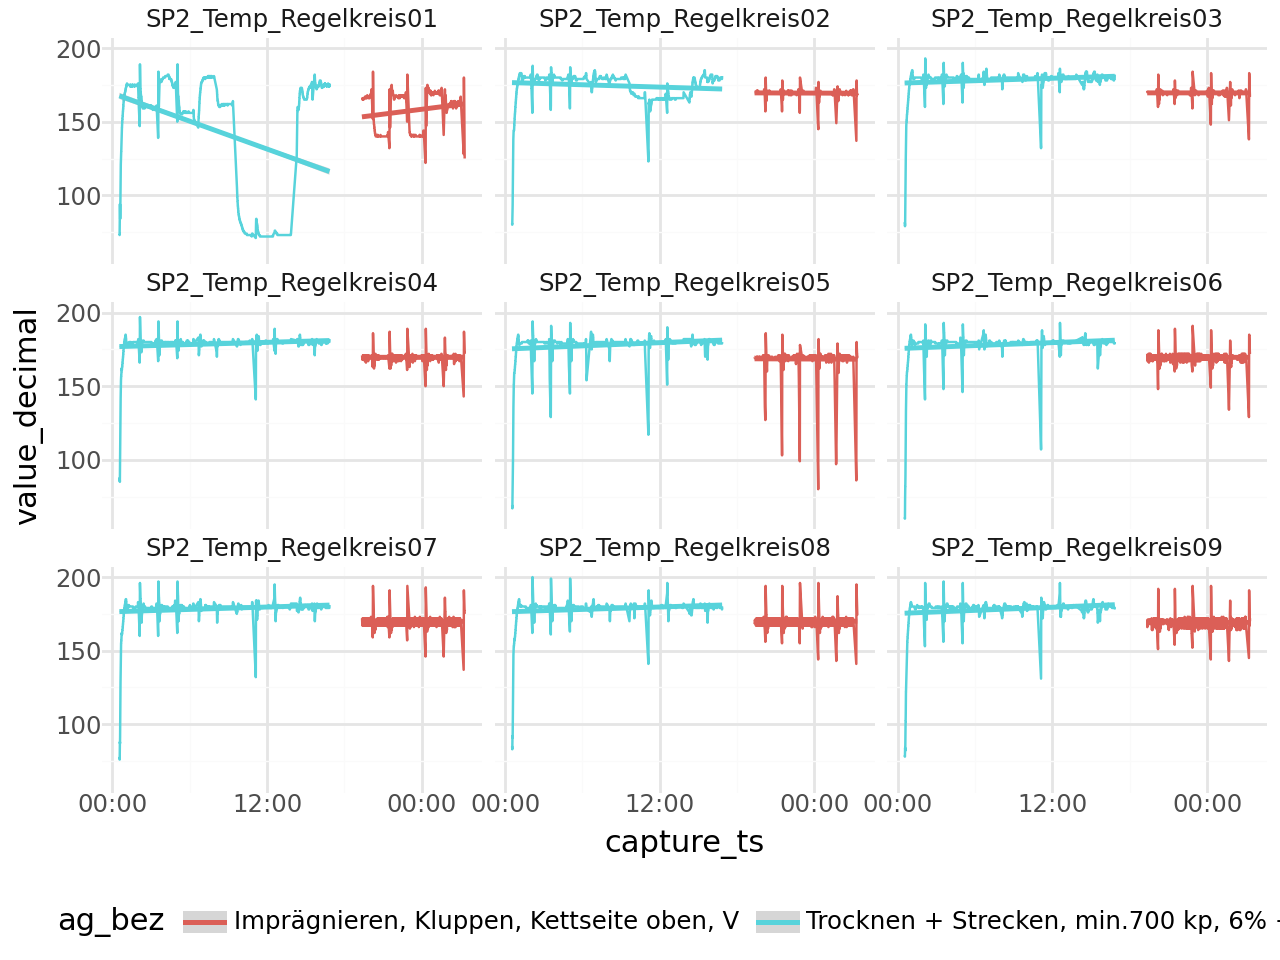

In [33]:
(
    ggplot(data_plot[data_plot['object_id'].isin(TEMPERATURES)], aes(x='capture_ts', y='value_decimal', color='ag_bez')) +
    geom_line() +
    theme_minimal()+
    scale_x_datetime(date_labels="%H:%M") +
    facet_wrap('~ object_id') +
    geom_smooth() +
    theme(legend_position="bottom")
)

### Envelope

In [34]:
temperature_envelope = data_long_clean[data_long_clean['object_id'].isin(TEMPERATURES)
    ].groupby(['object_id', 'artikel', 'ag_bez'])['value_decimal'].agg(
        percentile_01_temperature=lambda x: np.percentile(x, 1),
        percentile_99_temperature=lambda x: np.percentile(x, 99)
    )
temperature_envelope

percentile_01_temperature  \
object_id             artikel         ag_bez                                                                
SP2_Temp_Regelkreis01 C534K55 YB 1355 Trocknen und Strecken                                         162.0   
                                      Trocknen+Strecken,                                            106.0   
                      C550C73 YB 1570 Färben (Färbung 73), Strecken und Trockn                      137.0   
                                      Strecken (ca. 800 kp) und Trocknen                            144.0   
                      F511C14 ZB 1440 Imprägnieren, Kluppen, Kettseite oben, V                      157.0   
...                                                                                                   ...   
SP2_Temp_Regelkreis09 F511C14 ZB 1440 Trocknen + Strecken, min.700 kp, 6% +/-                       160.0   
                      F511C14 ZB 1590 Imprägnieren                                                  145.0   
                                      Imprägnieren, Kluppen, Kettseite oben, V                      150.0   
                                      Trocknen + Strecken, min.700 kp, 6% +/-                       154.0   
                                      Trocknen und Strecken                                         162.0   

                                                                                percentile_99_temperature  
object_id             artikel         ag_bez                                                               
SP2_Temp_Regelkreis01 C534K55 YB 1355 Trocknen und Strecken                                         182.0  
                                      Trocknen+Strecken,                                            189.0  
                      C550C73 YB 1570 Färben (Färbung 73), Strecken und Trockn                      191.0  
                                      Strecken (ca. 800 kp) und Trocknen                            182.0  
                      F511C14 ZB 1440 Imprägnieren, Kluppen, Kettseite oben, V                      180.0  
...                                                                                                   ...  
SP2_Temp_Regelkreis09 F511C14 ZB 1440 Trocknen + Strecken, min.700 kp, 6% +/-                       190.0  
                      F511C14 ZB 1590 Imprägnieren                                                  188.0  
                                      Imprägnieren, Kluppen, Kettseite oben, V                      187.0  
                                      Trocknen + Strecken, min.700 kp, 6% +/-                       190.0  
                                      Trocknen und Strecken                                         190.0  

[90 rows x 2 columns]

## Moisture

* Nearly all values are either `0` or `0.000916`
* Assume `0` is a faulty measurement
* Assume `0.000916` is the target value

### Example

* There are only 7 different values for moisture

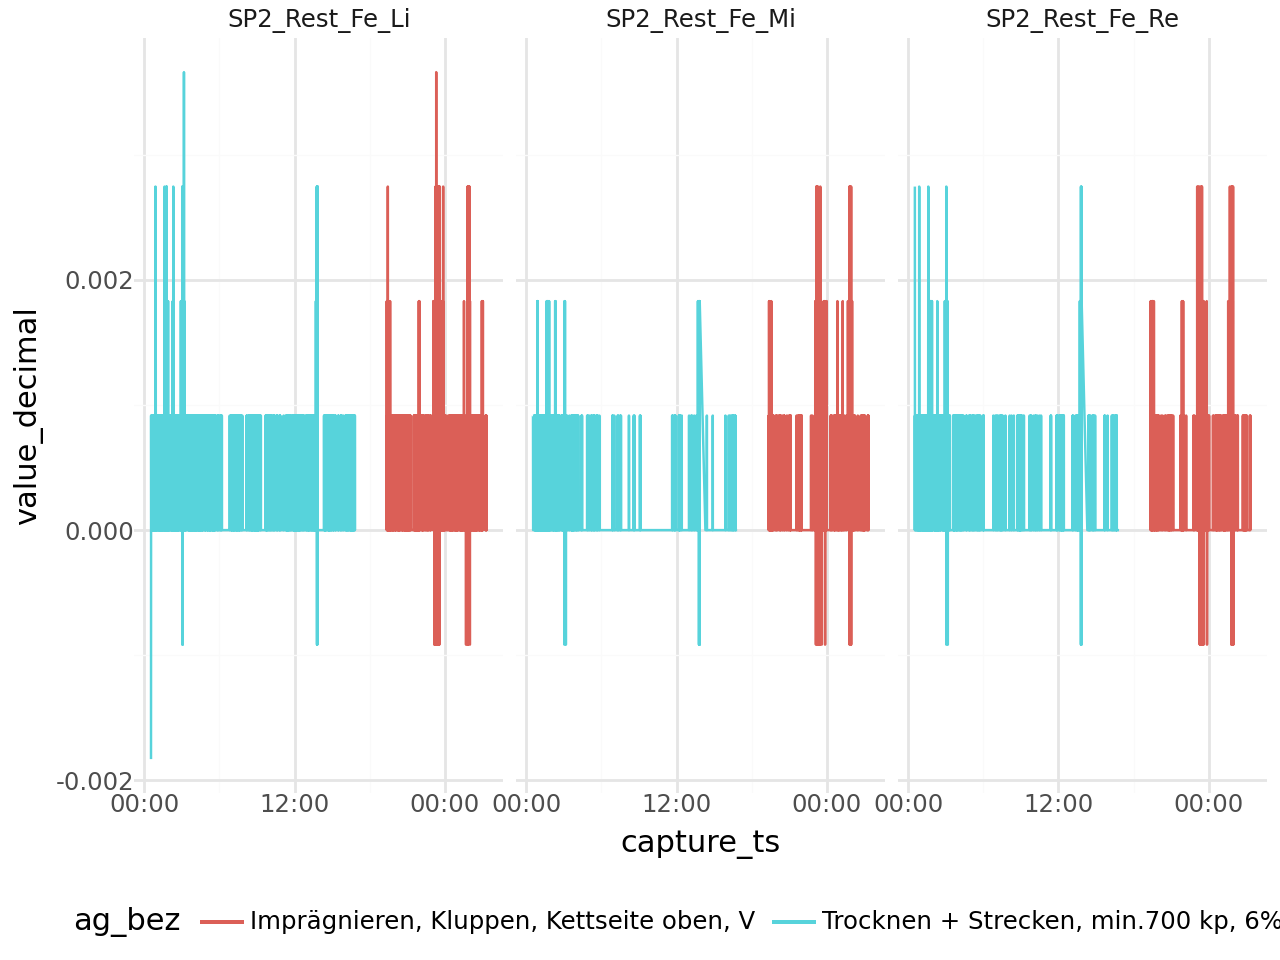

In [35]:
(
    ggplot(data_plot[data_plot['object_id'].isin(MOISTURES)], aes(x='capture_ts', y='value_decimal', color='ag_bez')) +
    geom_line() +
    theme_minimal()+
    scale_x_datetime(date_labels="%H:%M") +
    facet_wrap('~ object_id') +
    theme(legend_position="bottom")
)

In [36]:
data_wide_clean[MOISTURES].head()

,SP2_Rest_Fe_Li,SP2_Rest_Fe_Mi,SP2_Rest_Fe_Re
22591,0.000000,0.001831,0.001831
22592,-0.000916,0.000916,0.001831
22593,0.001831,0.001831,0.000000
22594,0.000916,0.002747,0.001831
22595,0.000000,0.001831,0.002747


In [37]:
moisture_values = data_long_clean[data_long_clean['object_id'].isin(MOISTURES)]['value_decimal'].unique().tolist()
moisture_values.sort()

In [38]:
moisture_mapping = {}
moisture_codes = [-2, -1, 0, 1, 2, 3, 4]
for v,c in zip(moisture_values, moisture_codes):
    moisture_mapping[v] = c

In [39]:
moisture_mapping

{-0.0018309999722987413: -2,
 -0.0009159999899566174: -1,
 0.0: 0,
 0.0009159999899566174: 1,
 0.0018309999722987413: 2,
 0.0027469999622553587: 3,
 0.0036619999445974827: 4}

In [40]:
for col in MOISTURES:
    data_wide_clean[f'{col}'] = data_wide_clean[col].map(moisture_mapping)

In [41]:
data_wide_clean[MOISTURES].head()

,SP2_Rest_Fe_Li,SP2_Rest_Fe_Mi,SP2_Rest_Fe_Re
22591,0,2,2
22592,-1,1,2
22593,2,2,0
22594,1,3,2
22595,0,2,3


In [42]:
for k,v in moisture_mapping.items():
  print(f"map {k} to {v}")

map -0.0018309999722987413 to -2
map -0.0009159999899566174 to -1
map 0.0 to 0
map 0.0009159999899566174 to 1
map 0.0018309999722987413 to 2
map 0.0027469999622553587 to 3
map 0.0036619999445974827 to 4


### Statistics

### Make categorical

In [43]:
data_long_clean = data_wide_clean.melt(
    id_vars=['capture_ts', 'artikel', 'artikel_bez', 'ag_bez', 'rleid'],
    var_name='object_id',
    value_name='value_decimal'
)

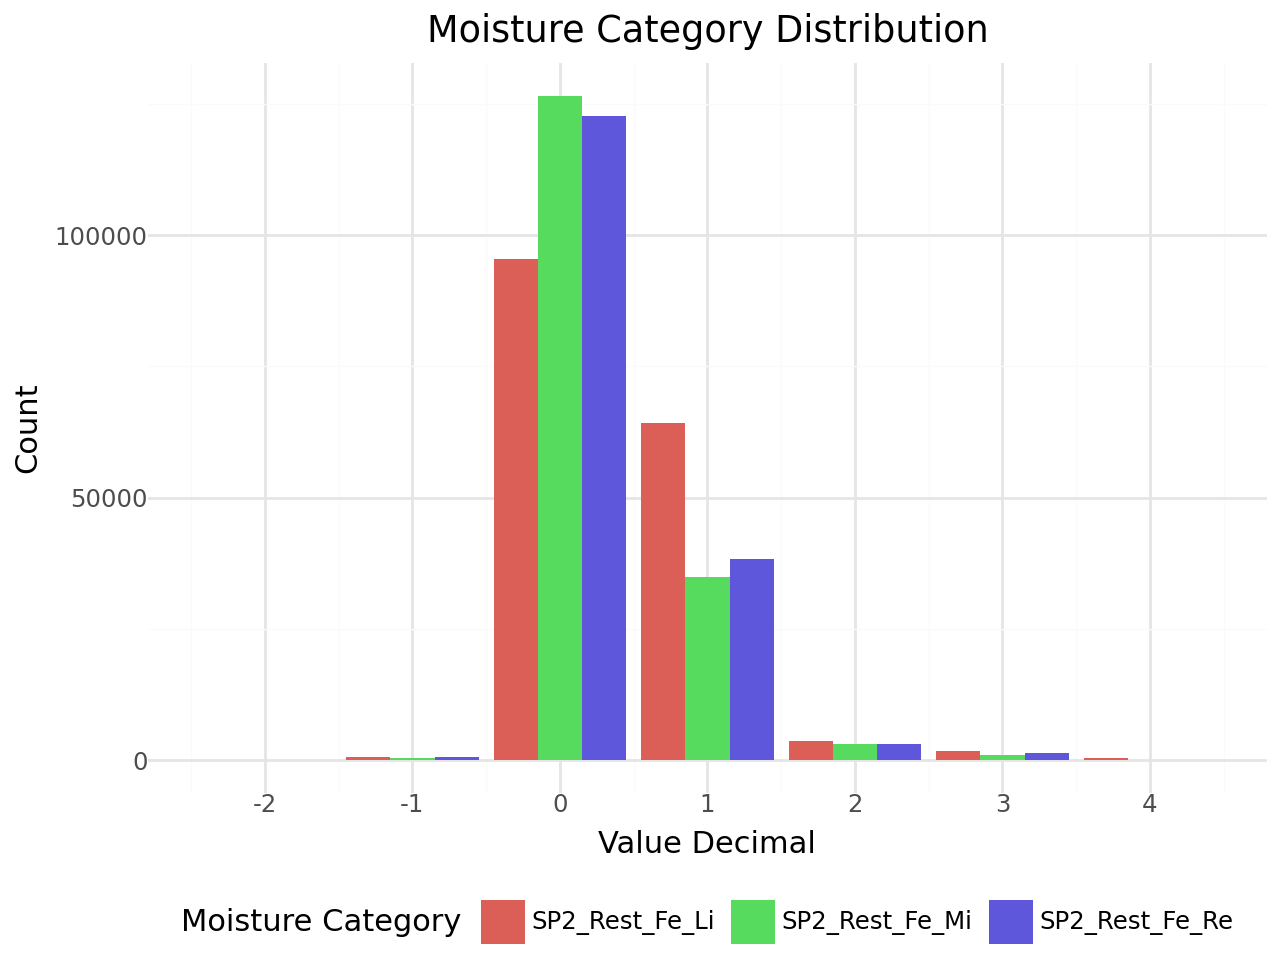

In [48]:
# Filter and prepare the data
filtered_data = data_long_clean[data_long_clean['object_id'].isin([f'{c}' for c in MOISTURES])]

# Group by 'object_id' and 'value_decimal' to count occurrences
grouped_data = (
    filtered_data.groupby(['object_id', 'value_decimal'])['capture_ts']
    .count()
    .reset_index()
    .rename(columns={'capture_ts': 'count'})
)

# Create a bar chart with plotnine
(
    ggplot(grouped_data, aes(x='value_decimal', y='count', fill='object_id')) +
    geom_bar(stat='identity', position='dodge') +
    theme_minimal() +
    labs(
        title='Moisture Category Distribution',
        x='Value Decimal',
        y='Count',
        fill='Moisture Category'
    ) +
    scale_x_continuous(breaks=[-2, -1, 0, 1, 2, 3, 4]) +
    theme(legend_position="bottom")
)

# Correlation

* `SP2_Temp_Regelkreis01` is not correlated with the other temperatures
* `SP2_Temp_Regelkreis02` to `SP2_Temp_Regelkreis09` are all strongly correlated
* `SP2_Meterz_Einl` and `SP2_Meterz_Ausl` are perfectly correlated: mass balance
* `SP2_Rest_Fe_Li` is weakly correlated with `SP2_Rest_Fe_Mi` and `SP2_Rest_Fe_Re`, who themselves are moderately correlated

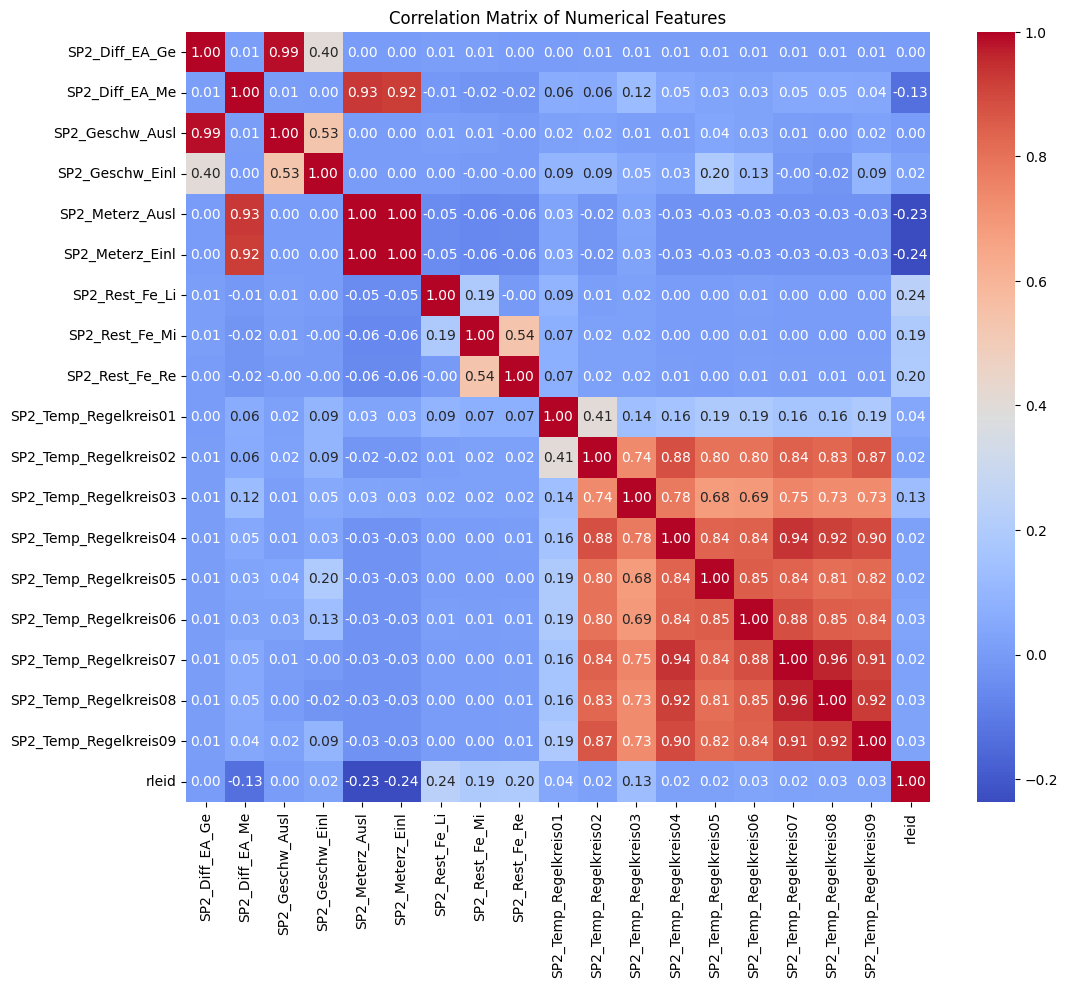

In [45]:
# prompt: Plot the result as a correlation matrix

# Assuming 'data_wide_clean' DataFrame is available from the previous code

# Select numerical columns for correlation analysis
numerical_cols = data_wide_clean.select_dtypes(include=np.number).columns

# Calculate the correlation matrix
correlation_matrix = data_wide_clean[numerical_cols].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Save data

## Cleaned wide

In [46]:
data_wide_clean.to_parquet('/content/drive/MyDrive/Juna/data/data_wide_clean.parquet', engine='pyarrow', index=False)

## Envelopes

In [47]:
speed_envelope.to_csv('/content/drive/MyDrive/Juna/data/speed_envelope.csv', index=False)
temperature_envelope.to_csv('/content/drive/MyDrive/Juna/data/moisture_envelope.csv', index=False)

***